# imports

In [2]:
%matplotlib notebook
from __future__ import division
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import IFrame

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
import itertools
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [4]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mymeta import proxify
from schlichtanders.mycontextmanagers import ignored

In [5]:
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

# Simple Posterior

For testing we choose a conjugate likelihood/prior combination such that the resulting posterior form is known in advance.

It seems the only combination with commonly known results is Gauss, considering that we need a distribution which can be expressed as a function of some standard random source, because of stochastic backpropagation.

As the final goal is to have more complex distributions than Gaussians, another distribution might

In [9]:
prior_u = 0
prior_s2 = 0.5

likelihood_s2 = 2

sample = np.random.normal(size=100, scale=4, loc=5)

posterior_s2 = 1 / (1/prior_s2 + len(sample)/likelihood_s2)
posterior_u = (prior_u/prior_s2 + sample.sum()/likelihood_s2) * posterior_s2

In [28]:
target_params = posterior_u, posterior_s2
target_params

(4.8190657222610351, 0.019230769230769232)

In [11]:
likelihood = tm.Merge(pm.Gauss(init_var=likelihood_s2),
                      ignore_references={'parameters_positive'})
likelihood

Merge2 { 'inputs': [], 'outputs': Gauss.outputs, 'parameters': [Gauss.mean]}

In [12]:
q = pm.Gauss()
q

Gauss2 { 'inputs': [],
  'outputs': Gauss2.outputs,
  'parameters': [Gauss2.mean],
  'parameters_positive': [Gauss2.var]}

In [13]:
prior = tm.fix_params(pm.Gauss(init_mean=prior_u, init_var=prior_s2))
prior

Gauss3_fixed { 'inputs': [], 'outputs': Gauss3.outputs}

In [14]:
model = tm.variational_bayes(likelihood, 'parameters', q, priors=prior)
model

variational_lower_bound { 'inputs': [],
  'kl_prior': variational_lower_bound.kl_prior,
  'logposterior': variational_lower_bound.logposterior,
  'logprior': variational_lower_bound.logprior,
  'n_data': variational_lower_bound.n_data,
  'outputs': Gauss.outputs,
  'parameters': [Gauss2.mean],
  'parameters_positive': [Gauss2.var]}

In [15]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))
flat

"Gauss2.var_squareplus_centered:Gauss2.mean_centered"

In [16]:
tm.d3viz(([flat] + model.logP['inputs'], model.logP['outputs']), 'tmp/model.html')
IFrame('tmp/model.html', width=700, height=500)

In [17]:
tm.reduce_all_identities()

In [18]:
loss = tm.loss_variational(model)
optimizer_kwargs = tm.numericalize(
    loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=0.01),
)
climin_args = izip(imap(lambda x:(x,), itertools.repeat(sample)), itertools.repeat({}))

In [19]:
opt = optimizer(
    identifier="adadelta",
#     steprate=1e-6,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


In [20]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
best_params = None
last_best_i = opt.n_iter

<IPython.core.display.Javascript object>


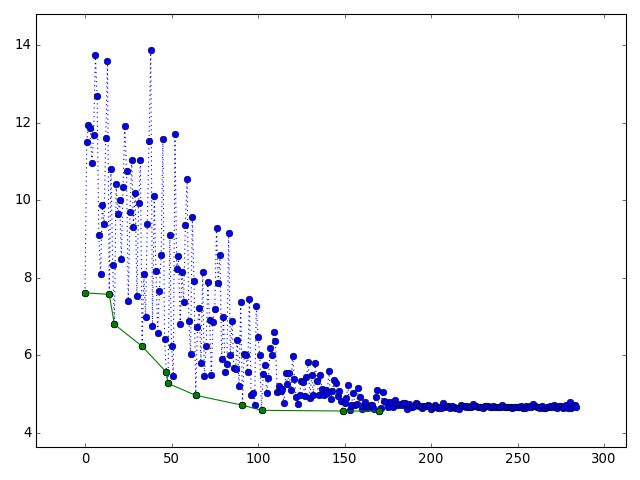

In [21]:
plt.figure()
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]

In [23]:
for info in opt:
    loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
    if opt.n_iter - last_best_i > 100:
        break
    if loss < best_loss:
        last_best_i = opt.n_iter
        best_loss = loss
        best_params = opt.wrt
        add_point(h_best, opt.n_iter, best_loss)
    add_point(h, opt.n_iter, loss)

In [24]:
best_loss

4.565355470691264

In [26]:
params = q['parameters'] + q['parameters_positive']
f_q_param = theano.function([flat], params)

In [31]:
for s, n, t in zip(map(str, params), f_q_param(best_params), target_params):
    print "%40s : %10g ~ %g" % (s, n, t)

                    Gauss2.mean_centered :    4.79049 ~ 4.81907
                      Gauss2.var_reparam :  0.0389252 ~ 0.0192308


We fortunately get roughly the parameters of the posterior. The variance seems overestimated, always, but still fine. Kind of a factor of two.

# Complex Posterior Normflows

In [106]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*(x- 0.5))
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [107]:
f = func.function()

<IPython.core.display.Javascript object>


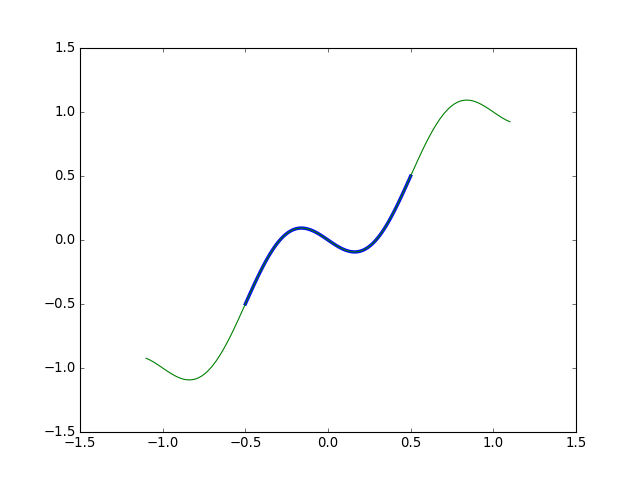

In [110]:
plt.figure()
num_x = np.linspace(-0.5, 0.5, 100)
plt.plot(num_x, [f([_num_x]) for _num_x in num_x], linewidth=3)
num_x = np.linspace(-1.1, 1.1, 100)
plt.plot(num_x, [f([_num_x]) for _num_x in num_x])


In [35]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge6 { 'inputs': [TensorConstant{(1,) of 0.5}], 'outputs': GaussianNoise.outputs}

In [36]:
sampler = likelihood.function()
data = np.array([sampler([0.65]) for n in range(5000)])

<IPython.core.display.Javascript object>


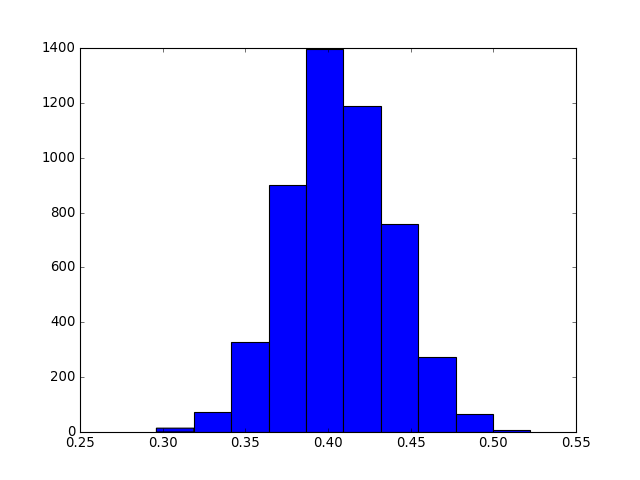

(array([   14.,    74.,   327.,   899.,  1395.,  1189.,   758.,   272.,
           66.,     6.]),
 array([ 0.29621363,  0.3188394 ,  0.34146517,  0.36409093,  0.3867167 ,
         0.40934247,  0.43196824,  0.454594  ,  0.47721977,  0.49984554,
         0.52247131]),
 <a list of 10 Patch objects>)

In [37]:
plt.figure()
plt.hist(data)

---

In [38]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
# base_posterior = tm.fix_params(pm.DiagGauss(1))
base_posterior = pm.DiagGauss(1)
posterior = base_posterior
# transform_posteriors = [dm.PlanarTransform() for _ in range(4)] + [dm.LocScaleTransform()]
transform_posteriors = [dm.RadialTransform() for _ in range(4)]
for tr in transform_posteriors:
    posterior = tm.normalizing_flow(tr, posterior)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [39]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

In [40]:
model

variational_lower_bound2 { 'inputs': [],
  'kl_prior': variational_lower_bound2.kl_prior,
  'logposterior': variational_lower_bound2.logposterior,
  'logprior': variational_lower_bound2.logprior,
  'n_data': variational_lower_bound2.n_data,
  'norm_det': RadialTransform4.norm_det,
  'outputs': GaussianNoise.outputs,
  'parameters': [ RadialTransform4.z0_centered,
                  RadialTransform3.z0_centered,
                  RadialTransform2.z0_centered,
                  RadialTransform.z0_centered,
                  DiagGauss2.mean_centered],
  'parameters_positive': [ RadialTransform4.alpha_reparam,
                           RadialTransform4.beta+alpha_reparam,
                           RadialTransform3.alpha_reparam,
                           RadialTransform3.beta+alpha_reparam,
                           RadialTransform2.alpha_reparam,
                           RadialTransform2.beta+alpha_reparam,
                           RadialTransform.alpha_reparam,
                   

In [41]:
batch_size = 10
n_batches = len(data) // batch_size
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=itertools.cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=1),
)

# climin_args = izip(imap(lambda x:(x,), itertools.repeat(data)), itertools.repeat({}))
climin_args = izip(imap(lambda x:(x,), chunk(batch_size, itertools.cycle(data))), itertools.repeat({}))

opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


In [42]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, data)
best_params = None
last_best_i = opt.n_iter // n_batches

<IPython.core.display.Javascript object>


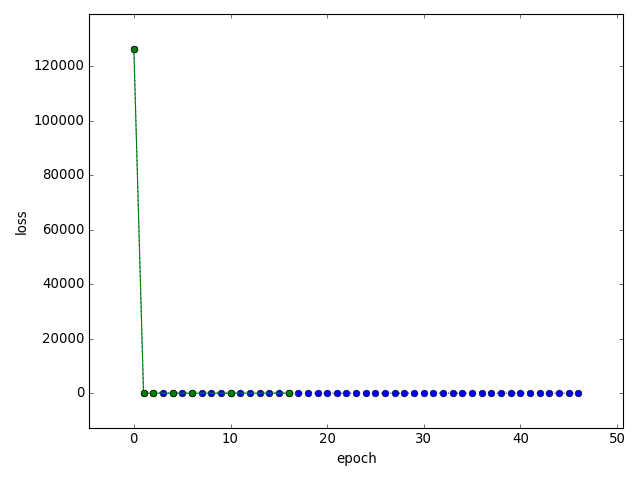

In [43]:
plt.figure()
# plt.yscale('log')
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]
plt.ylabel("loss")
plt.xlabel("epoch")

In [44]:
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):
        current_epoch = opt.n_iter // n_batches
        _loss = optimizer_kwargs['num_loss'](opt.wrt, data)
        if current_epoch - last_best_i > 30:
            break
        if _loss < best_loss:
            last_best_i = current_epoch
            best_loss = _loss
            best_params = opt.wrt
            add_point(h_best, current_epoch, best_loss)
        add_point(h, current_epoch, _loss)

In [45]:
best_loss

-2.0351403214236603

In [46]:
posterior_sampler = theano.function([flat], posterior['outputs'])

<IPython.core.display.Javascript object>


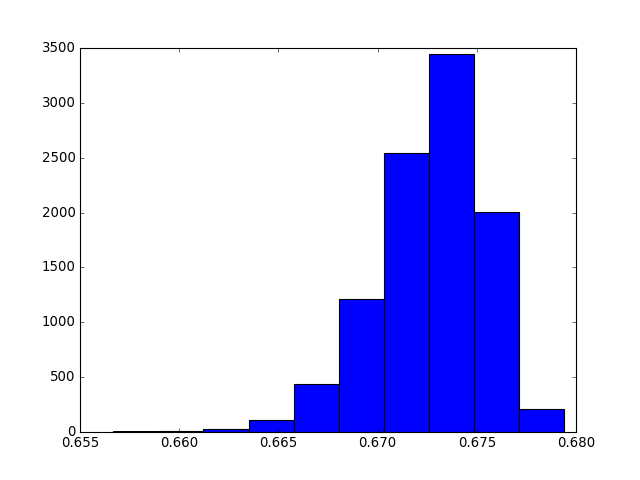

In [47]:
plt.figure()
plt.hist(np.array([posterior_sampler(best_params) for _ in range(10000)]))
pass

This seems as if it cannot find the two/three modes of the underlying posterior 

# Complex Posterior Mixture

In [51]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*x)
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [52]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge10 { 'inputs': [TensorConstant{(1,) of 0.5}], 'outputs': GaussianNoise2.outputs}

In [53]:
sampler = likelihood.function()
data = np.array([sampler([0.5]) for n in range(5000)])

---

In [54]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
base_posteriors = [pm.DiagGauss(1) for _ in range(3)]
posterior =pm.Mixture(*base_posteriors)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [55]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

In [56]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += tm.prox_reparameterize(model['parameters_psumto1'], tm.softmax, tm.softmax_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

In [57]:
flat

"DiagGauss4.mean_centered:DiagGauss5.mean_centered:DiagGauss6.mean_centered:DiagGauss4.var_squareplus_centered:DiagGauss5.var_squareplus_centered:DiagGauss6.var_squareplus_centered:Mixture.mixture_probs_softmax_centered"

In [58]:
tm.d3viz(loss, "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=700)

In [59]:
batch_size = 10
n_batches = len(data) // batch_size
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=itertools.cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=1),
)

# climin_args = izip(imap(lambda x:(x,), itertools.repeat(data)), itertools.repeat({}))
climin_args = izip(imap(lambda x:(x,), chunk(batch_size, itertools.cycle(data))), itertools.repeat({}))

opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


In [60]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, data)
best_params = None
last_best_i = opt.n_iter // n_batches

<IPython.core.display.Javascript object>


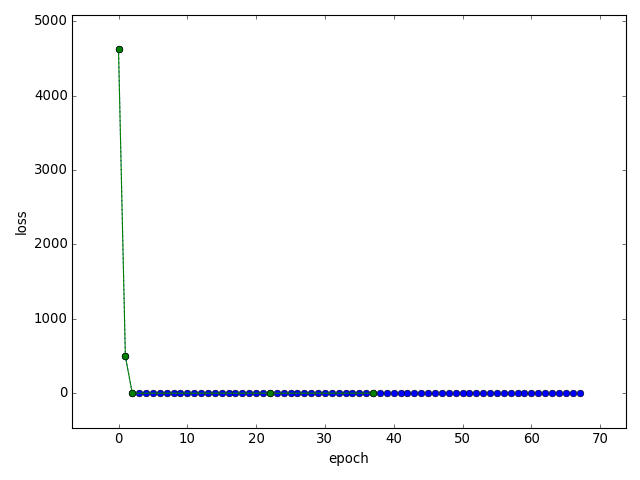

In [61]:
plt.figure()
# plt.yscale('log')
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]
plt.xlabel("epoch")
plt.ylabel("loss")

In [62]:
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):
        current_epoch = opt.n_iter // n_batches
        _loss = optimizer_kwargs['num_loss'](opt.wrt, data)
        if current_epoch - last_best_i > 30:
            break
        if _loss < best_loss:
            last_best_i = current_epoch
            best_loss = _loss
            best_params = opt.wrt
            add_point(h_best, current_epoch, best_loss)
        add_point(h, current_epoch, _loss)

In [63]:
best_loss

-2.0246270441188599

In [64]:
posterior_sampler = theano.function([flat], posterior['outputs'])

<IPython.core.display.Javascript object>


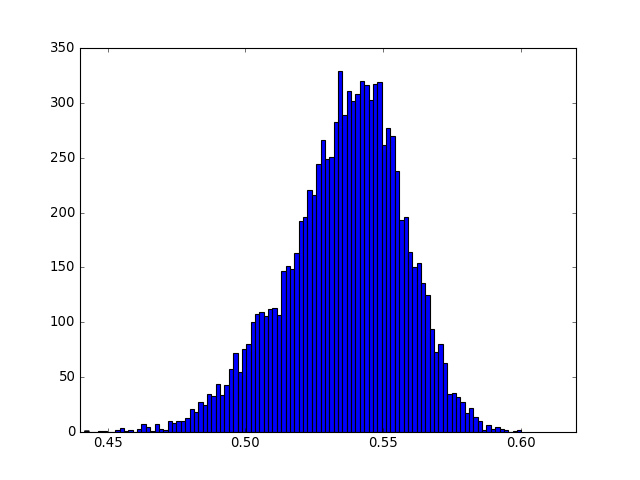

In [65]:
plt.figure()
plt.hist(np.array([posterior_sampler(best_params) for _ in range(10000)]), bins=100)
pass

In [66]:
f_mixture_probs = theano.function([flat], posterior.mixture_probs)
f_mixture_probs(best_params)

array([ 0.69467681,  0.10448228,  0.2008409 ])

TODO test more noise on initial parameters

TODO check why normflows gives that low log-likelihoods (seems like a bad minima)

# Two Parameters Complex Posterior Mixture

<IPython.core.display.Javascript object>


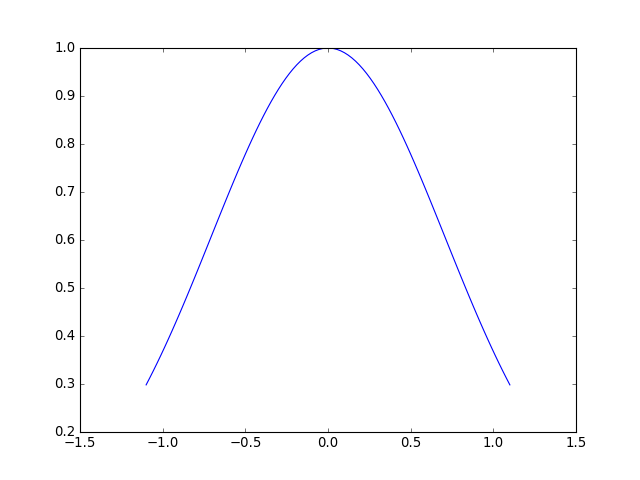

In [182]:
plt.figure()
# _x = np.linspace(-10, 10, 200)
_x = num_x
sigma2 = 1
plt.plot(_x, np.exp(-_x**2))

In [229]:
x = tm.as_tensor_variable([0.5, 0.5]) #T.vector()
y = 0.3 * T.sin(2*np.pi*(x[0]- 0.5)) + x[0] + x[1] #+ np.exp(-x[1]**2)
func = tm.Model(inputs=[x], outputs=y, name="sin")
f = func.function()

In [230]:
@np.vectorize
def myfunc(a,b):
    return f([a,b])

<IPython.core.display.Javascript object>


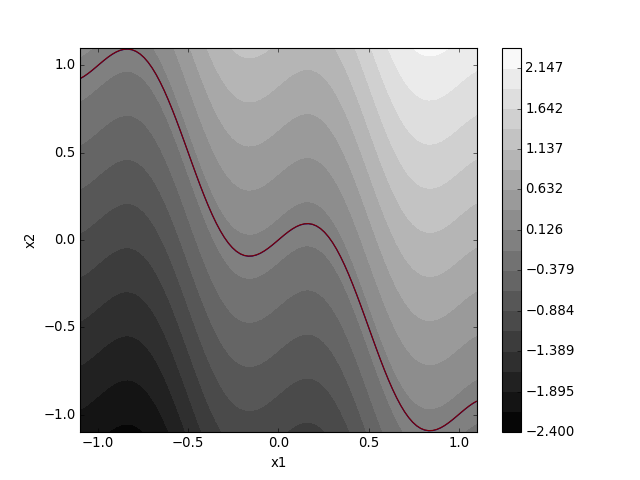

In [232]:
plt.figure()
# num_x = np.linspace(-0, 1, 100)
num_x = np.linspace(-1.1, 1.1, 100)
# num_x = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(num_x, num_x)

levels = np.linspace(-2.4, 2.4, 20)
h = plt.contourf(X1, X2, myfunc(X1, X2), cmap=plt.cm.gray, levels=levels)
l=0
h2 = plt.contour(X1, X2, myfunc(X1, X2), cmap=plt.cm.jet, levels=[l, l+0.001])
plt.xlabel("x1")
plt.ylabel("x2")

plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(h)

In [241]:
p = h2.collections[1].get_paths()[0]

<IPython.core.display.Javascript object>


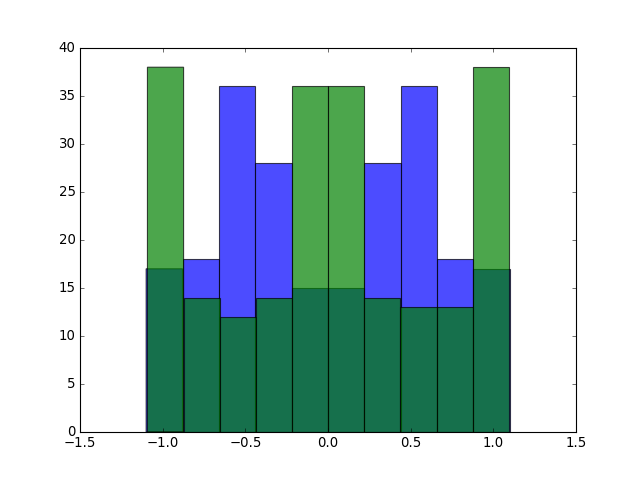

(array([ 38.,  14.,  12.,  14.,  36.,  36.,  14.,  13.,  13.,  38.]),
 array([ -1.09214095e+00,  -8.73512764e-01,  -6.54884573e-01,
         -4.36256382e-01,  -2.17628191e-01,   1.00000000e-03,
          2.19628191e-01,   4.38256382e-01,   6.56884573e-01,
          8.75512764e-01,   1.09414095e+00]),
 <a list of 10 Patch objects>)

In [245]:
v = p.vertices
x = v[:,0]
y = v[:,1]
plt.figure()
plt.hist(x, alpha=0.7)
plt.hist(y, alpha=0.7)

In [77]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge12 { 'inputs': [TensorConstant{(2,) of 0.5}], 'outputs': GaussianNoise6.outputs}

In [78]:
sampler = likelihood.function()
data = np.array([sampler([0.5, 0.5]) for n in range(5000)])

<IPython.core.display.Javascript object>


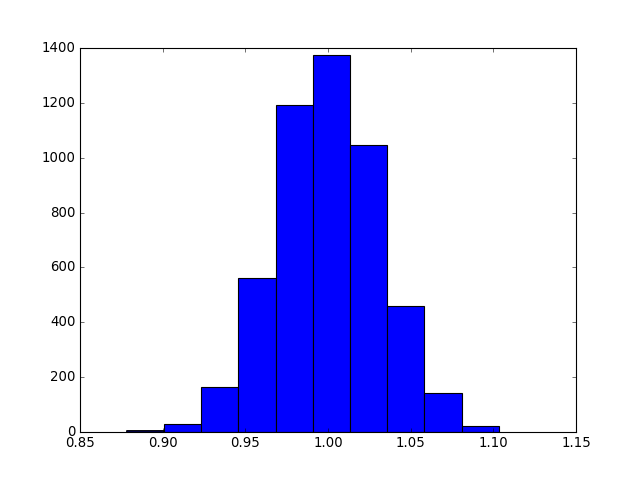

(array([    5.,    30.,   163.,   562.,  1193.,  1374.,  1047.,   461.,
          144.,    21.]),
 array([ 0.87823222,  0.90074127,  0.92325031,  0.94575936,  0.96826841,
         0.99077745,  1.0132865 ,  1.03579554,  1.05830459,  1.08081364,
         1.10332268]),
 <a list of 10 Patch objects>)

In [79]:
plt.figure()
plt.hist(data)

In [85]:
def center_isoline(a):
    @np.vectorize
    def x2(x1):
        return a - x1 - 3/10*np.sin(2*np.pi*x1)
    return x2

<IPython.core.display.Javascript object>


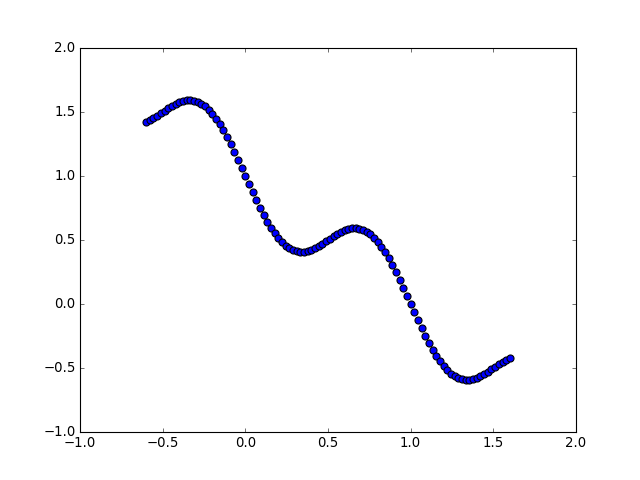

In [86]:
plt.figure()
num_x2 = center_isoline(1)(num_x)
plt.scatter(num_x, num_x2, s=40)

<IPython.core.display.Javascript object>


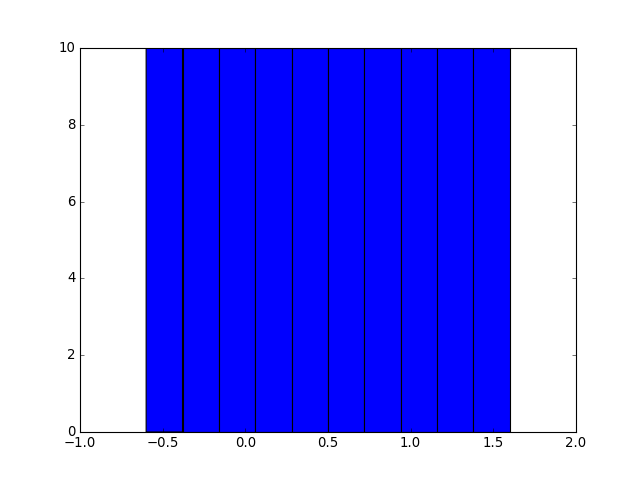

(array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.]),
 array([-0.6 , -0.38, -0.16,  0.06,  0.28,  0.5 ,  0.72,  0.94,  1.16,
         1.38,  1.6 ]),
 <a list of 10 Patch objects>)

In [87]:
plt.figure()
plt.hist(num_x)

In [221]:
x = tm.as_tensor_variable([0.5, 0.5]) #T.vector()
y = (0.3 * T.sin(2*np.pi*(x[0]- 0.5)) + np.exp(-x[0]**2)
   + np.exp(-x[1]**2))
#+ np.exp(-x[1]**2))
func = tm.Model(inputs=[x], outputs=y, name="sin")
f = func.function()

In [222]:
@np.vectorize
def myfunc(a,b):
    return f([a,b])

<IPython.core.display.Javascript object>


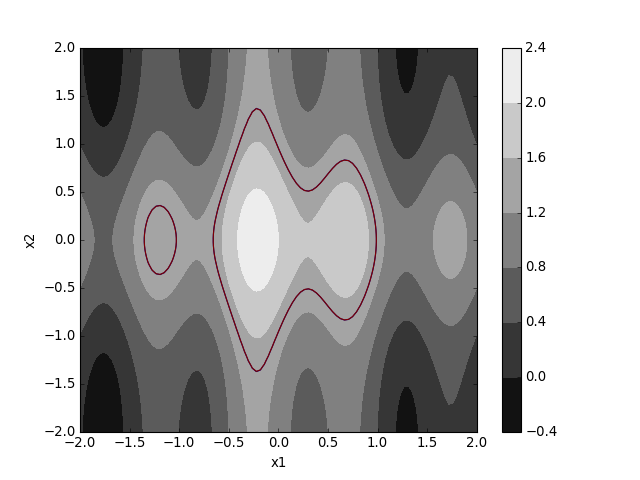

In [225]:
plt.figure()
# num_x = np.linspace(-0, 1, 100)
num_x = np.linspace(-1.1, 1.1, 100)
num_x = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(num_x, num_x)

# levels = np.linspace(-2.4, 2.4, 20)
h = plt.contourf(X1, X2, myfunc(X1, X2), cmap=plt.cm.gray)#, levels=levels)
l=1.4
h2 = plt.contour(X1, X2, myfunc(X1, X2), cmap=plt.cm.jet, levels=[l, l+0.001])
plt.xlabel("x1")
plt.ylabel("x2")

plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(h)